In [1]:
## Loading the Libraries
import re
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV,RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import pad_sequences, to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import panel as pn
import warnings
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dense, Dropout
def show_panel(df, top=20):
    return pn.widgets.Tabulator(df.head(top),
                                show_index=False,
                                pagination='local', 
                                page_size=10)

pn.extension('tabulator')
pn.widgets.Tabulator.theme = 'bootstrap'

In [2]:
## Loading the data
data = pd.read_excel('data.xlsx')
print('The dimension of the dataset is:',data.shape)

The dimension of the dataset is: (24780, 4)


# Exploratory Data Analsyis

In [3]:
data.head(3)

,Keyword,Title,Description,Date
0,Job Market,Trudeau responds to Ford urging feds to cut Me...,Prime Minister Justin Trudeau says the federal...,2024-11-12
1,Job Market,Services around Winnipeg will commemorate Reme...,Each year in November millions of Canadians pa...,2024-11-09
2,Job Market,Man accused of property encroachment violation...,Former Dawson City Mayor Bill Kendrick has fil...,2024-11-08


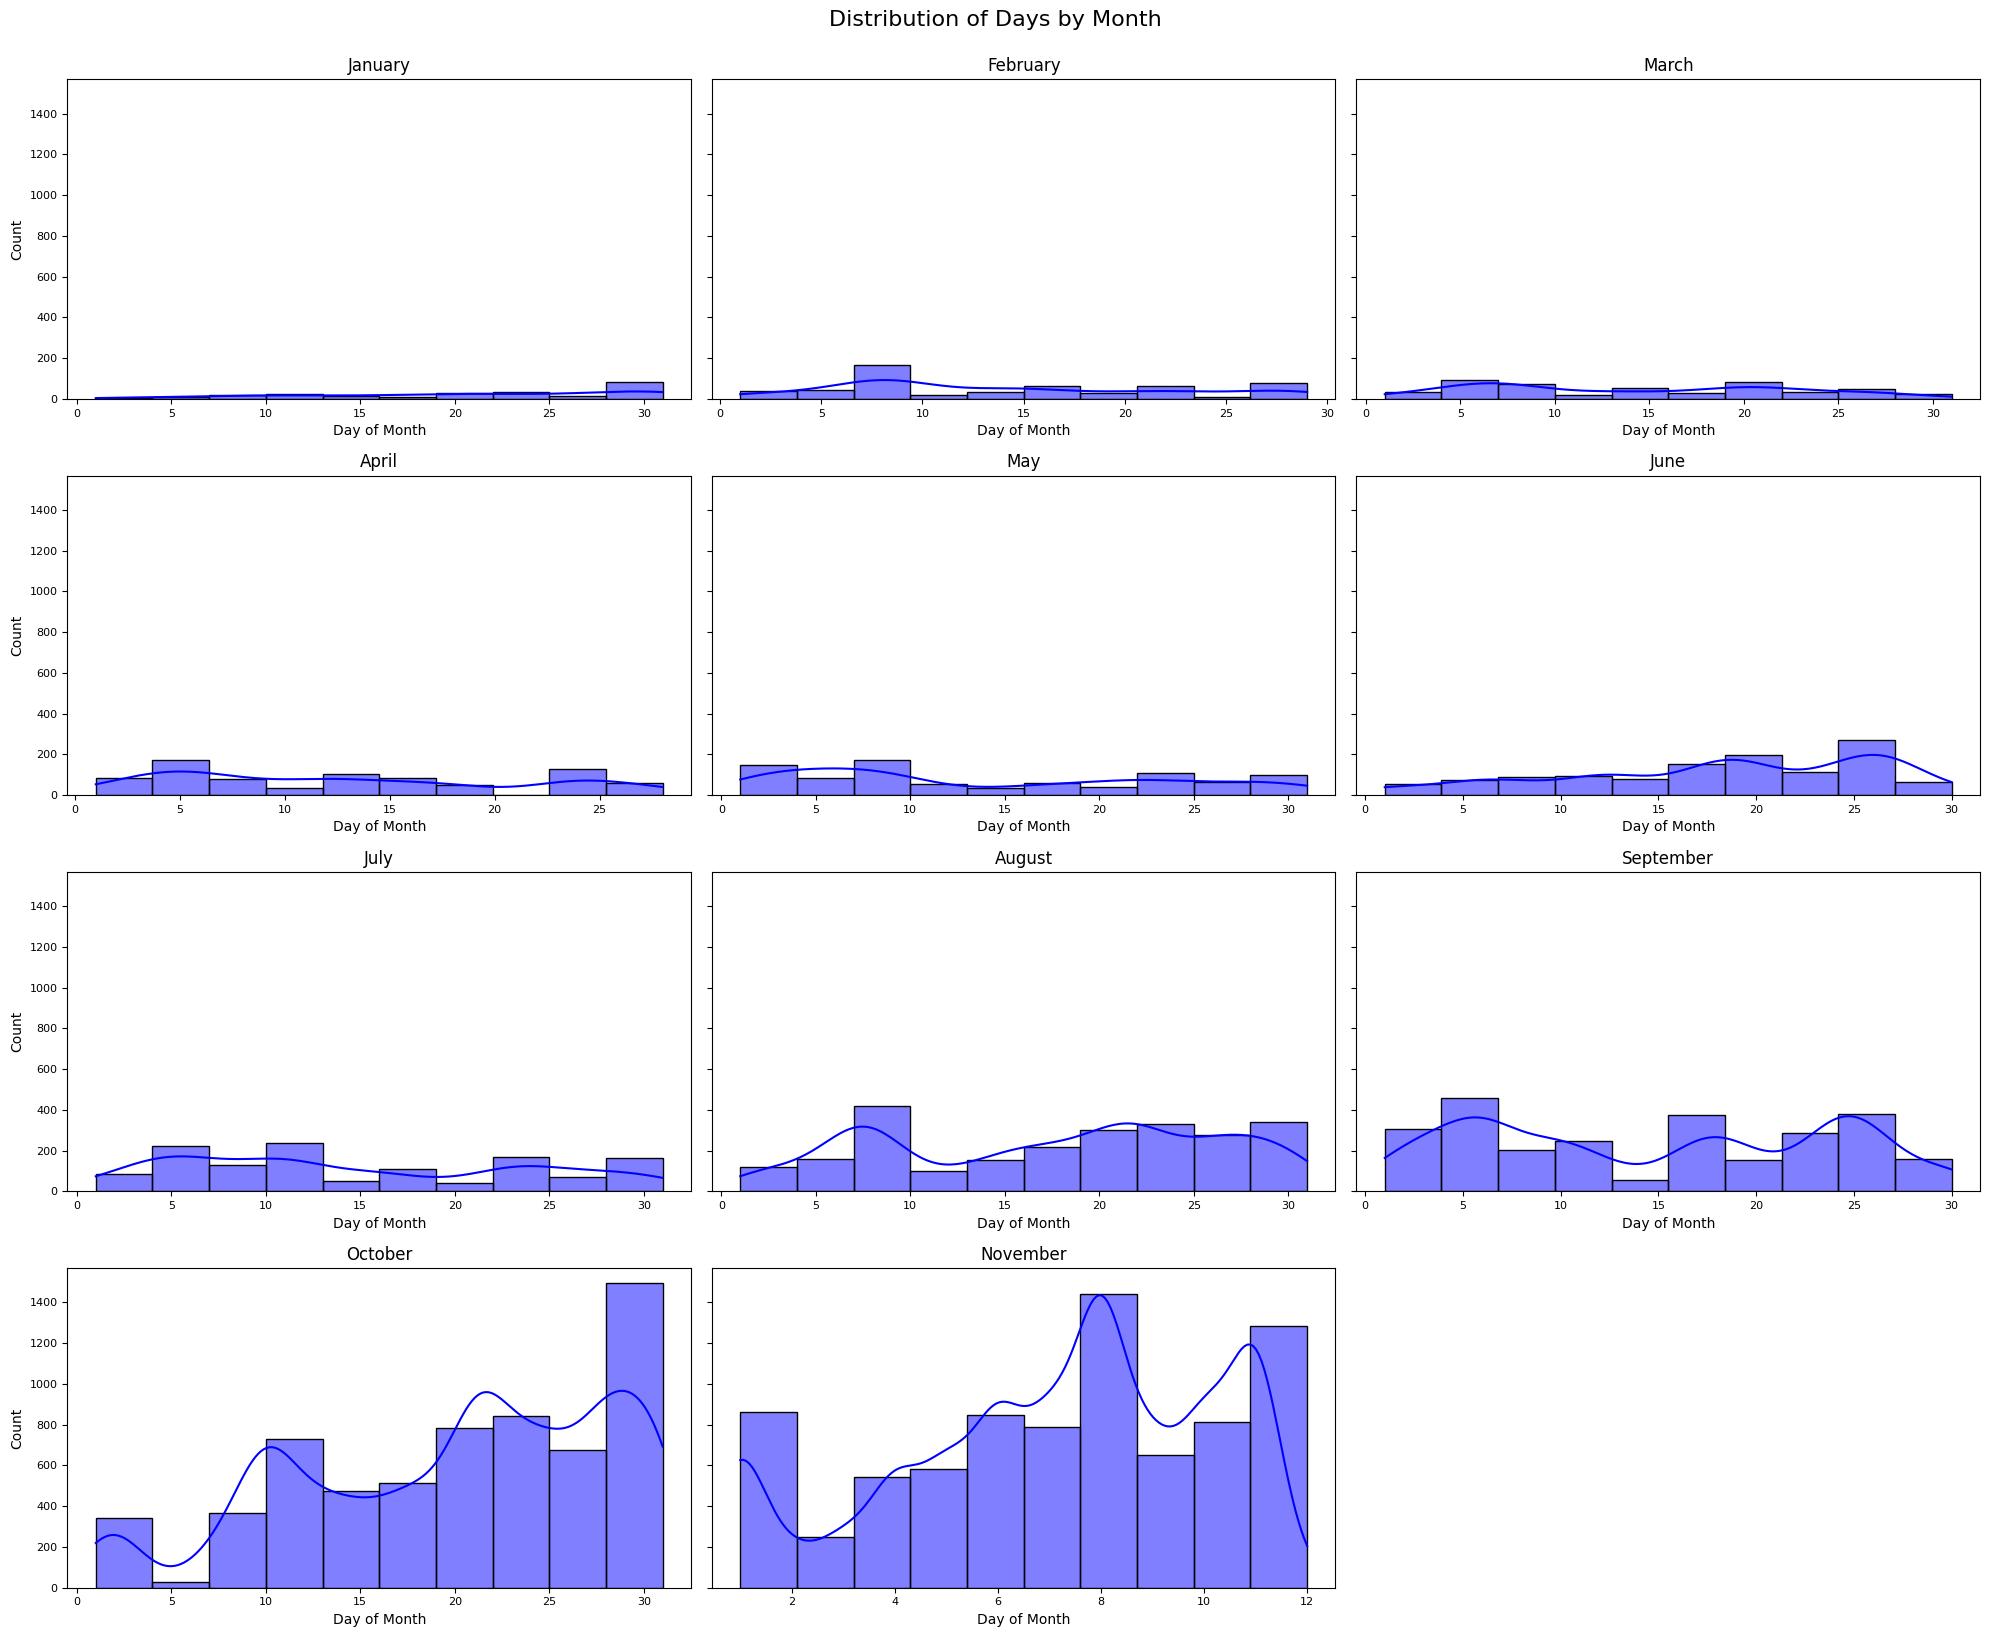

In [4]:
df = data.copy()

# Convert Date column to datetime format and extract Month and Day
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime
df['Month'] = df['Date'].dt.month_name()  # Extract month name
df['Day'] = df['Date'].dt.day  # Extract day of the month

# Get unique months and sort them in calendar order
unique_months = df['Month'].unique()
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
unique_months = sorted(df['Month'].unique(), key=lambda x: month_order.index(x))

# Create side-by-side subplots for each month
n_cols = 3  # Number of columns
n_rows = -(-len(unique_months) // n_cols)  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

for i, month in enumerate(unique_months):
    month_data = df[df['Month'] == month]
    sns.histplot(month_data['Day'], bins=10, kde=True, ax=axes[i], color="blue", edgecolor="black")
    axes[i].set_title(f'{month}', fontsize=12)
    axes[i].set_xlabel('Day of Month', fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visuals
plt.tight_layout()
plt.suptitle("Distribution of Days by Month", fontsize=16, y=1.02)  # Add a global title
plt.show()



In [5]:
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Bar plot for counts by month
bar_fig = px.bar(
    df['Month'].value_counts().sort_index(),
    title='Number of Articles by Month in 2024',
    labels={'index': 'Month', 'value': 'Count'},
    color_discrete_sequence=['#636EFA']
)
bar_fig.update_layout(xaxis_title='Month', yaxis_title='Count')


# Bar plot for counts by unique values in the 'Keyword' column
keyword_fig = px.bar(
    df['Keyword'].value_counts(),
    title='Frequency of Keywords',
    labels={'index': 'Keyword', 'value': 'Count'},
    color_discrete_sequence=['#FFA07A'],
    template="plotly_white"
)

# Create subplots to display both plots side by side
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Number of Articles by Month in 2024", "Articles By Keywords"],
    column_widths=[0.5, 0.5]
)

# bar plot for articles by month
for trace in bar_fig.data:
    fig.add_trace(trace, row=1, col=1)

# bar plot for frequency of keywords
for trace in keyword_fig.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(
    height=600, width=1200, showlegend=False, title_text="Article and Keyword Distribution"
)

# Show the plot
fig.show()

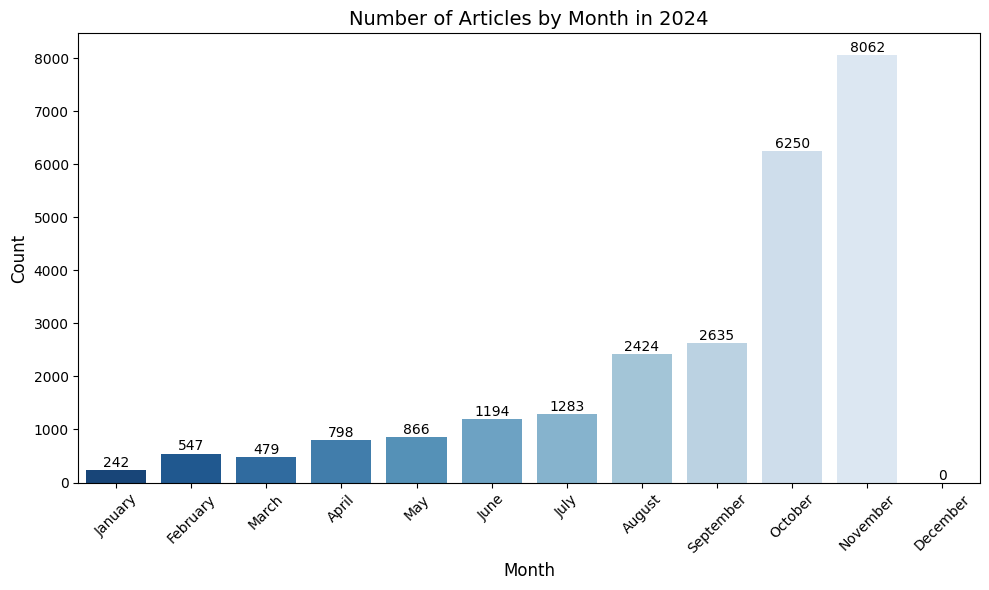

In [6]:

month_counts = df['Month'].value_counts().reindex(month_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=month_counts.index, y=month_counts.values, palette="Blues_r")
for i, value in enumerate(month_counts.values):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
plt.title("Number of Articles by Month in 2024", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
for i in range(0,3):
    print("Title:", data.loc[i, 'Title'])
    print("Description:", data.loc[i, 'Description'])

Title: Trudeau responds to Ford urging feds to cut Mexico from North American trade agreement
Description: Prime Minister Justin Trudeau says the federal government is going to continue to work with the U.S. and ‘hopefully Mexico’ to ensure they are united in their ‘desire to protect good jobs.’ Ontario Premier Doug Ford said in a statement Tuesday that Mexico has become a ‘backdoor for Chinese cars, auto parts and other products into Canadian and American markets.’
Title: Services around Winnipeg will commemorate Remembrance Day | CBC News
Description: Each year in November millions of Canadians pay tribute and collectively remember military servicemen who died for their country, and a number of services and ceremonies will be held around Winnipeg on Monday.
Title: Man accused of property encroachment violations in Dawson City files his defence against town | CBC News
Description: Former Dawson City Mayor Bill Kendrick has filed his defence against the town's encroachment violation la

In [8]:
data.isnull().sum()

Keyword        0
Title          0
Description    0
Date           0
dtype: int64

In [9]:
duplicates = data[data.duplicated()]
print('The number of duplicate rows are:',len(duplicates))

The number of duplicate rows are: 23413


# Data Preparation

The following Changes are made to preprocess then data
- Removing the duplicate articles
- The '|CIBC News' part to removed from the titles
- Merging the 'Title' and 'Description' coloumns and creating a new column named 'Articles'
- Lowercasing
- Removing punctuation
- Removing stopwords

In [10]:
data = data.drop_duplicates()
data['Title'] = data['Title'].str.replace(r'\s\|\s.*$', '', regex=True)
data.shape

(1367, 4)

In [11]:
# Combine Title and Description
data['Article'] = data['Title'] + " " + data['Description']
data.head(2)

,Keyword,Title,Description,Date,Article
0,Job Market,Trudeau responds to Ford urging feds to cut Me...,Prime Minister Justin Trudeau says the federal...,2024-11-12,Trudeau responds to Ford urging feds to cut Me...
1,Job Market,Services around Winnipeg will commemorate Reme...,Each year in November millions of Canadians pa...,2024-11-09,Services around Winnipeg will commemorate Reme...


In [12]:
data = data.drop(['Title','Description'], axis=1)

In [13]:
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def preprocess_data(sentence, remove_stopwords=True):
    # Remove punctuation
    sentence = re.sub(r"[^\w\s]", "", sentence)
    # Convert to lowercase
    sentence = sentence.lower()
    # Split into words
    words = sentence.split()
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

# data["Article"] = data["Article"].apply(lambda x: preprocess_data(x, remove_stopwords=False))
# removing stop words
data["Article"] = data["Article"].apply(lambda x: preprocess_data(x, remove_stopwords=True))


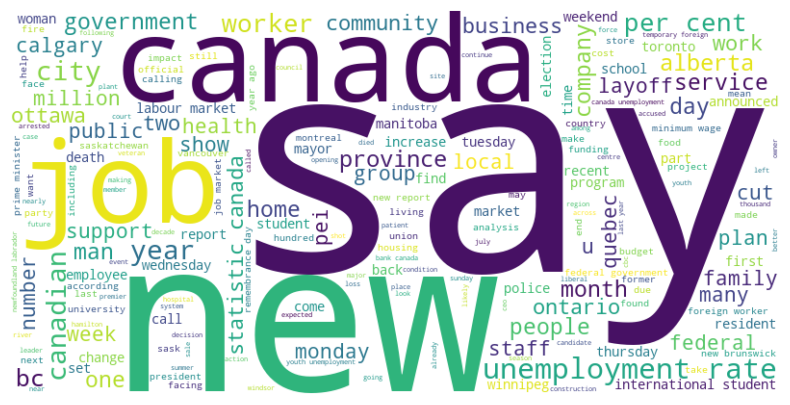

In [14]:
 # Joining all articles into one large string
text = ' '.join(data['Article'].dropna()) 
# word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
from collections import Counter
all_text = " ".join(data["Article"])
all_words = all_text.split()

# frequency of each word
word_counts = Counter(all_words)

#most common 10 words
most_common_words = word_counts.most_common(10)  

print("Most frequent words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

Most frequent words:
say: 504
canada: 406
job: 359
new: 272
year: 241
rate: 219
unemployment: 200
canadian: 195
worker: 170
government: 161


# Sentiment Labelling

## With TextBlob

In [16]:
class make_labels:
    
    def __init__(self, df, text_column):
        self.df = df
        self.text_column = text_column

    def sentiment_val(self):
        # Adding polarity score
        self.df['blob_sent'] = self.df[self.text_column].apply(lambda row: TextBlob(row).sentiment.polarity)
        # Adding sentiment category
        self.df['Sentiment'] = self.df['blob_sent'].apply(
            lambda x: 'Positive' if x > 0.1 else 'Negative' if x < -0.1 else 'Neutral'
        )
        return self.df

labels = make_labels(data, 'Article')
data = labels.sentiment_val()
data.head(3)

,Keyword,Date,Article,blob_sent,Sentiment
0,Job Market,2024-11-12,trudeau responds ford urging fed cut mexico no...,0.175,Positive
1,Job Market,2024-11-09,service around winnipeg commemorate remembranc...,-0.100,Neutral
2,Job Market,2024-11-08,man accused property encroachment violation da...,0.000,Neutral


In [17]:
sentiment_counts = data['Sentiment'].value_counts().reset_index()
fig = px.bar(sentiment_counts, x='Sentiment', y='count', title='Sentiment Distribution by Textblob', color='Sentiment',
             template="plotly_white") 
fig.show()

In [18]:
label_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
data['label'] = data['Sentiment'].map(label_mapping)
data.head(2)

,Keyword,Date,Article,blob_sent,Sentiment,label
0,Job Market,2024-11-12,trudeau responds ford urging fed cut mexico no...,0.175,Positive,2
1,Job Market,2024-11-09,service around winnipeg commemorate remembranc...,-0.100,Neutral,1


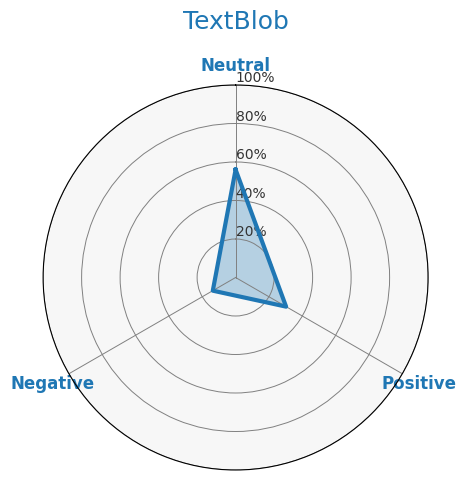

In [ ]:
from matplotlib.colors import ListedColormap
sentiment_counts = data['Sentiment'].value_counts()
categories = sentiment_counts.index.tolist()
values = sentiment_counts.values.tolist()

# Normalizing values to percentages
total = sum(values)
values = [v / total * 100 for v in values]
values += values[:1]  # to close the radar chart
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Radar chart for TextBlob
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
ax.grid(color='grey', linestyle='-', linewidth=0.7)

ax.set_facecolor('#f7f7f7')
ax.plot(angles, values, color='#1f77b4', linewidth=3, linestyle='solid')  # Blue color for the line
ax.fill(angles, values, color='#1f77b4', alpha=0.3)  # Light blue for the fill

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, color='#1f77b4', fontweight='bold')
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], color="#333333", fontsize=10)

plt.title('TextBlob', size=18, color='#1f77b4', pad=20)
plt.show()

## With GPT 4o mini

In [20]:
######### Labelling with GPT 4o mini

# import openai

# #  OpenAI API key
# api_key = "#####"
# openai.api_key = api_key

# # Function to classify sentiment
# def get_sentiment_2(text):
#     prompt = f"""
#     Read the articles given below carefully and analyze its sentiment in the context of job market analysis. Label the sentiment as Negative, Neutral, or Positive based on its relevance to job market trends, opportunities, or challenges for the text below:
#     {text}
#     The output should be in only one word.
#     """
#     try:
#         response = openai.ChatCompletion.create(
#             model="gpt-4o-mini",  # Replace with the correct model name
#             messages=[
#                 {"role": "system", "content": "You are a helpful assistant."},
#                 {"role": "user", "content": prompt}
#             ],
#             max_tokens=10,  # Keeping it short for one-word output
#             temperature=0.7,
#             top_p=0.75
#         )
#         # Extracting the response text
#         return response['choices'][0]['message']['content'].strip()
#     except Exception as e:
#         print(f"Error: {e}")
#         return None

# # Adding a new column for sentiment classification
# data['sentiment_gpt'] = data['Article'].apply(get_sentiment_2)



In [21]:
data.columns

Index(['Keyword', 'Date', 'Article', 'blob_sent', 'Sentiment', 'label'], dtype='object')

In [22]:
data = pd.read_excel('labled_data.xlsx')
data['gpt_label'] = data['sentiment_gpt'].map(label_mapping)
data.head(2)
data["Article"] = data["Article"].apply(lambda x: preprocess_data(x, remove_stopwords=True))
data.head(2)

,Keyword,Date,Article,blob_sent,Sentiment,label,sentiment_gpt,gpt_label
0,Job Market,2024-11-12,trudeau responds ford urging fed cut mexico no...,0.115,Positive,2,Neutral,1
1,Job Market,2024-11-09,service around winnipeg commemorate remembranc...,-0.100,Neutral,1,Neutral,1


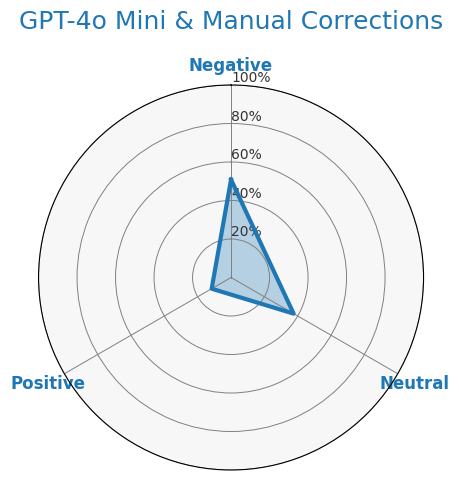

In [23]:
sentiment_counts = data['sentiment_gpt'].value_counts()
categories = sentiment_counts.index.tolist()
values = sentiment_counts.values.tolist()

# Normalize values to percentages
total = sum(values)
values = [v / total * 100 for v in values]
values += values[:1]  # to close the radar chart
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Radar chart for GPT-4o Mini
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
ax.grid(color='grey', linestyle='-', linewidth=0.7)

# Set background color and style
# Set background color and style
ax.set_facecolor('#f7f7f7')
ax.plot(angles, values, color='#1f77b4', linewidth=3, linestyle='solid')  # Blue color for the line
ax.fill(angles, values, color='#1f77b4', alpha=0.3)  # Light blue for the fill

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, color='#1f77b4', fontweight='bold')
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], color="#333333", fontsize=10)

plt.title('GPT-4o Mini & Manual Corrections',size=18, color='#1f77b4', pad=20)
plt.show()

In [24]:
sentiment_counts_gpt = data['sentiment_gpt'].value_counts().reset_index()
fig = px.bar(sentiment_counts_gpt, x='sentiment_gpt', y='count', title='Sentiment Distribution by GPT-4o Mini and Manual Corrections', color='sentiment_gpt', 
             template="plotly_white") 
fig.show()

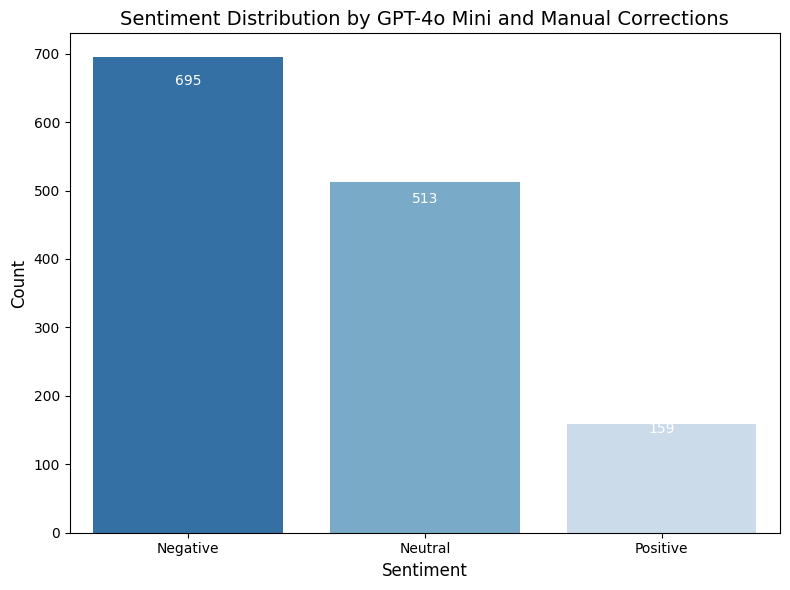

In [25]:
sentiment_counts = data['sentiment_gpt'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

sentiment_counts = sentiment_counts.sort_values(by='Count', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts, palette="Blues_r")

for i, value in enumerate(sentiment_counts['Count']):
    plt.text(i, value - (value * 0.05), str(value), ha='center', va='center', fontsize=10, color='white')

plt.title("Sentiment Distribution by GPT-4o Mini and Manual Corrections", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Embeddings

In [26]:
import spacy
def get_spacy_embeddings(texts):
    # Load the small English model from SpaCy
    nlp = spacy.load('en_core_web_sm')

    embeddings = []
    for text in texts:
        doc = nlp(text)
        # Get the mean of all token vectors for the document
        embeddings.append(doc.vector)

    return np.array(embeddings)

spacy_embeddings = get_spacy_embeddings(data['Article'])
print("Embeddings dimension by spacy is:", spacy_embeddings.shape)


Embeddings dimension by spacy is: (1367, 96)


In [27]:
### DistilBertModel
import torch
from transformers import DistilBertTokenizer, DistilBertModel

def get_distilbert_embeddings(texts):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    model.eval()

    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())

    return np.array(embeddings)

# embeddings
embeddings = get_distilbert_embeddings(data['Article'])
print("Embeddings dimension by DistilBert  is:",embeddings.shape)

Embeddings dimension by DistilBert  is: (1367, 768)


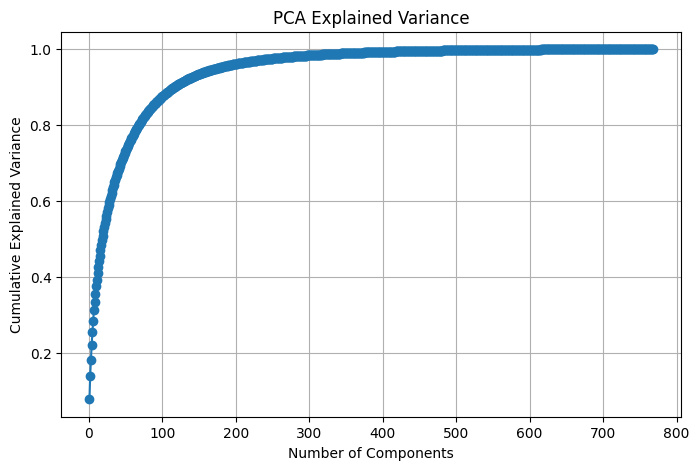

In [28]:
def find_optimal_pca_components(embeddings):
    """
    Finds the optimal number of PCA components by plotting explained variance ratio.
    Args:
        embeddings (numpy.ndarray): Original high-dimensional embeddings.
    """
    pca = PCA()
    pca.fit(embeddings)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid()
    plt.show()
    
    return cumulative_variance

cumulative_variance = find_optimal_pca_components(embeddings)

In [29]:
def reduce_embeddings_with_pca(embeddings, n_components):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

# Reduced dimensionality to 100 components
reduced_embeddings = reduce_embeddings_with_pca(embeddings, n_components = 100)
print("embeddings dimension is:",reduced_embeddings.shape)

embeddings dimension is: (1367, 100)


# Modelling

## Machine Learning Models

In [30]:
##### ML models pipiline
class nlp_evals:
    def __init__(self, df, corpus, label, embeddings=None, title='accuracy evaluation'):
        """
        Initialize the nlp_evals class.

        Args:
            df (pd.DataFrame): The dataset.
            corpus (str): The column name containing text data.
            label (str): The column name containing labels.
            embeddings (np.ndarray): Precomputed embeddings. Default is None.
            title (str): Title for the results plot. Default is 'accuracy evaluation'.
        """
        self.df = deepcopy(df)
        self.corpus = corpus
        self.label = label
        self.embeddings = embeddings
        self.seed = 32
        self.num_folds = 8
        self.title = title

        if self.embeddings is None:
            raise ValueError("Embeddings must be provided to the class.")

    def tts(self, ratio=0.2):
        """
        Train-test split.

        Args:
            ratio (float): Test size ratio. Default is 0.2.
        """
        Y = self.df[self.label]
        X = self.embeddings

        X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=ratio, random_state=32, stratify=Y
        )

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        print("Train/test split completed!")

    def define_models(self, models):
        """
        Define models to evaluate.

        Args:
            models (list of tuples): List of (model_name, model_instance).
        """
        self.models = models
        print("Models set!")

    
    
    def kfold(self):
        """
        Perform k-fold cross-validation, training, and testing.
        Generate classification reports for both training and testing data.
        Includes macro and weighted precision, recall, and F1-score.
        """
        self.results = []
        self.names = []
        self.test_results = []
        self.train_results = []
        self.cv_results = []

        # To store macro and weighted metrics
        self.train_macro_f1 = []
        self.test_macro_f1 = []
        self.train_weighted_f1 = []
        self.test_weighted_f1 = []

        self.train_macro_precision = []
        self.test_macro_precision = []
        self.train_weighted_precision = []
        self.test_weighted_precision = []

        self.train_macro_recall = []
        self.test_macro_recall = []
        self.train_weighted_recall = []
        self.test_weighted_recall = []

        self.train_classification_reports = {}
        self.test_classification_reports = {}

        print("Model, CV mean, CV std, Train acc, Test acc, Train macro F1, Test macro F1, Train weighted F1, Test weighted F1")

        for name, model in self.models:
            # Cross-validation
            kfold = KFold(n_splits=self.num_folds, shuffle=True, random_state=self.seed)
            cv_results = cross_val_score(model, self.X_train, self.y_train, cv=kfold, scoring='accuracy')
            self.results.append(cv_results)
            self.names.append(name)
            self.cv_results.append(cv_results.mean())

            # Train and evaluate
            model.fit(self.X_train, self.y_train)
            y_train_pred = model.predict(self.X_train)
            y_test_pred = model.predict(self.X_test)

            acc_train = accuracy_score(self.y_train, y_train_pred)
            acc_test = accuracy_score(self.y_test, y_test_pred)

            # Extract metrics from classification report
            train_report = classification_report(self.y_train, y_train_pred, output_dict=True)
            test_report = classification_report(self.y_test, y_test_pred, output_dict=True)

            # Macro F1
            macro_train_f1 = train_report['macro avg']['f1-score']
            macro_test_f1 = test_report['macro avg']['f1-score']

            # Weighted F1
            weighted_train_f1 = train_report['weighted avg']['f1-score']
            weighted_test_f1 = test_report['weighted avg']['f1-score']

            # Macro Precision and Recall
            macro_train_precision = train_report['macro avg']['precision']
            macro_test_precision = test_report['macro avg']['precision']
            macro_train_recall = train_report['macro avg']['recall']
            macro_test_recall = test_report['macro avg']['recall']

            # Weighted Precision and Recall
            weighted_train_precision = train_report['weighted avg']['precision']
            weighted_test_precision = test_report['weighted avg']['precision']
            weighted_train_recall = train_report['weighted avg']['recall']
            weighted_test_recall = test_report['weighted avg']['recall']

            # Append metrics
            self.train_results.append(acc_train)
            self.test_results.append(acc_test)

            self.train_macro_f1.append(macro_train_f1)
            self.test_macro_f1.append(macro_test_f1)
            self.train_weighted_f1.append(weighted_train_f1)
            self.test_weighted_f1.append(weighted_test_f1)

            self.train_macro_precision.append(macro_train_precision)
            self.test_macro_precision.append(macro_test_precision)
            self.train_weighted_precision.append(weighted_train_precision)
            self.test_weighted_precision.append(weighted_test_precision)

            self.train_macro_recall.append(macro_train_recall)
            self.test_macro_recall.append(macro_test_recall)
            self.train_weighted_recall.append(weighted_train_recall)
            self.test_weighted_recall.append(weighted_test_recall)

            # Print results
            msg = (f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f}) "
                f"{acc_train:.4f} {acc_test:.4f} {macro_train_f1:.4f} {macro_test_f1:.4f} "
                f"{weighted_train_f1:.4f} {weighted_test_f1:.4f}")
            print(msg)

            # Store classification reports
            self.train_classification_reports[name] = train_report
            self.test_classification_reports[name] = test_report

        print("Evaluation finished!")

    def get_classification_reports(self):
        """
        Retrieve classification reports for all models.

        Returns:
            dict: A dictionary containing train and test classification reports.
        """
        return {
            "train": self.train_classification_reports,
            "test": self.test_classification_reports,
        }
        
    def plot_results(self):
        ldf_res = pd.DataFrame({
            'cv': self.cv_results,
            'train_accuracy': self.train_results,
            'test_accuracy': self.test_results,
            'train_macro_f1': self.train_macro_f1,
            'test_macro_f1': self.test_macro_f1,
            'train_weighted_f1': self.train_weighted_f1,
            'test_weighted_f1': self.test_weighted_f1,
            'train_macro_precision': self.train_macro_precision,
            'test_macro_precision': self.test_macro_precision,
            'train_weighted_precision': self.train_weighted_precision,
            'test_weighted_precision': self.test_weighted_precision,
            'train_macro_recall': self.train_macro_recall,
            'test_macro_recall': self.test_macro_recall,
            'train_weighted_recall': self.train_weighted_recall,
            'test_weighted_recall': self.test_weighted_recall
        })

        plot_df = ldf_res.melt()
        local_names = deepcopy(self.names) * len(ldf_res.columns)
        plot_df['names'] = local_names

        ptable = pd.pivot_table(plot_df, values='value', index='variable', columns='names')

        fig, ax = plt.subplots(figsize=(10, 6))
        sns.heatmap(ptable, annot=True, fmt=".2f", ax=ax, cmap='crest')
        plt.title(self.title)
        plt.ylabel("Metrics")
        plt.xlabel("Models")
        plt.tight_layout()
        plt.show()

### With DistillBert Embeddings

In [30]:
evals_nlp = nlp_evals(df=data,            # define the corpus dataframe
                      corpus='Article', # define which column contains the corpus
                      label='gpt_label',  # define the column which contains the label
                      title='Macro and Weighted Accuracies of the Models (DistillBert Embeddings)',
                      embeddings=reduced_embeddings) 

In [31]:
evals_nlp.tts()

Train/test split completed!


In [32]:
# hyperparameter grids
param_grids = {
    'LR': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['lbfgs', 'saga']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'CART': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'RF': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, 20, 30],
        'min_samples_split': [5, 10, 20, 30, 40],
        'min_samples_leaf': [5, 10, 20, 30, 40],
        'criterion': ['gini', 'entropy']
    },
    'NB': {  # Naive Bayes does not require hyperparameter tuning in this case
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Gaussian Naive Bayes
    },
    'XGB': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 1, 5],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    }
}

# Models with base initializations
base_models = {
    'LR': LogisticRegression(random_state=32),
    'KNN': KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(random_state=32),
    'SVM': SVC(probability=True, random_state=32),
    'RF': RandomForestClassifier(random_state=32),
    'NB': GaussianNB(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=32)
}

# Initialize tuned models list
tuned_models = []

# Hyperparameter tuning for each model
for model_name, model in base_models.items():
    print(f"Tuning {model_name}...")
    if model_name in param_grids:  # Check if hyperparameter grid exists for the model
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[model_name],
            n_iter= 10,  # Number of parameter settings sampled
            scoring='accuracy',
            cv= 3,  # 10-fold cross-validation
            random_state=32,
            verbose=1,
            n_jobs=-1  # Use all available cores
        )
        search.fit(evals_nlp.X_train, evals_nlp.y_train)
        best_model = search.best_estimator_
        print(f"Best parameters for {model_name}: {search.best_params_}")
    else:
        # Models without hyperparameter tuning (e.g., GaussianNB with default params)
        best_model = model.fit(evals_nlp.X_train, evals_nlp.y_train)

    tuned_models.append((model_name, best_model))

# tuned models in the evals_nlp pipeline
evals_nlp.define_models(tuned_models)

Tuning LR...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for LR: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
Tuning KNN...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for KNN: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}
Tuning CART...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for CART: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'gini'}
Tuning SVM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for SVM: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Tuning RF...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for RF: {'n_estimators': 200, 'min_samples_split': 30, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}
Tuning NB...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for NB: {'var_smoothing': 1e-09}
Tuning XGB...
Fitting 3 folds

In [33]:
evals_nlp.kfold()

Model, CV mean, CV std, Train acc, Test acc, Train macro F1, Test macro F1, Train weighted F1, Test weighted F1
LR: 0.7119 (0.0309) 0.7621 0.6752 0.6813 0.6034 0.7501 0.6673
KNN: 0.7337 (0.0242) 0.9963 0.7664 0.9951 0.7190 0.9963 0.7571
CART: 0.6688 (0.0171) 0.9780 0.6861 0.9647 0.6197 0.9778 0.6895
SVM: 0.7695 (0.0276) 0.9936 0.8102 0.9930 0.7955 0.9936 0.8105
RF: 0.7200 (0.0167) 0.8637 0.7664 0.7105 0.5744 0.8364 0.7270
NB: 0.6396 (0.0514) 0.6935 0.6423 0.6625 0.5909 0.6905 0.6372
XGB: 0.7777 (0.0254) 0.9936 0.7920 0.9930 0.7489 0.9936 0.7888
Evaluation finished!


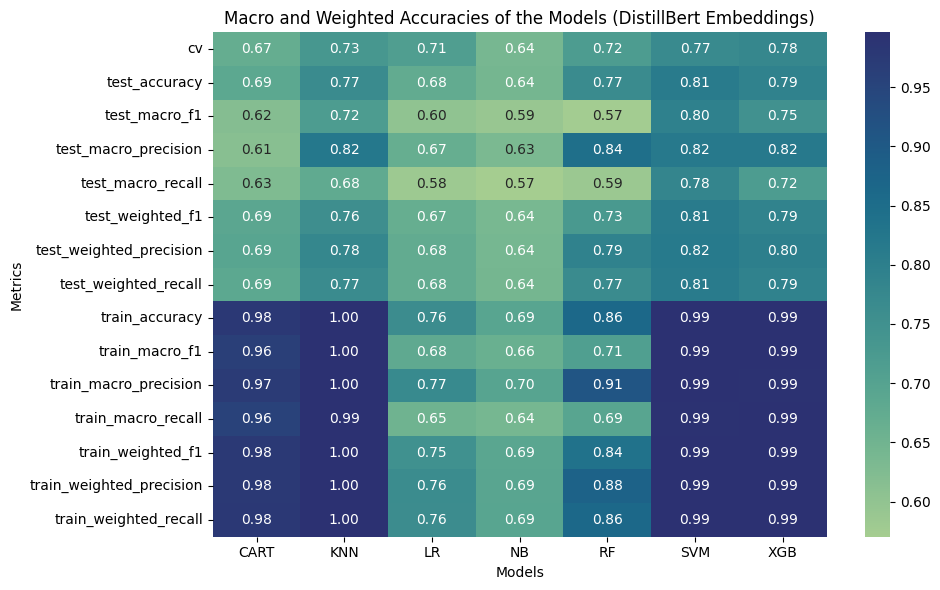

In [34]:
evals_nlp.plot_results()

In [35]:
reports = evals_nlp.get_classification_reports()

# training classification reports
print("Training Classification Reports:")
for model_name, report in reports['train'].items():
    print(f"Model: {model_name}")
    print(pd.DataFrame(report))

Training Classification Reports:
Model: LR
                    0           1           2  accuracy    macro avg  \
precision    0.759878    0.761905    0.789474  0.762123     0.770419   
recall       0.899281    0.702439    0.354331  0.762123     0.652017   
f1-score     0.823723    0.730964    0.489130  0.762123     0.681273   
support    556.000000  410.000000  127.000000  0.762123  1093.000000   

           weighted avg  
precision      0.764077  
recall         0.762123  
f1-score       0.750050  
support     1093.000000  
Model: KNN
                    0           1           2  accuracy    macro avg  \
precision    0.996416    0.997549    0.992126   0.99634     0.995364   
recall       1.000000    0.992683    0.992126   0.99634     0.994936   
f1-score     0.998205    0.995110    0.992126   0.99634     0.995147   
support    556.000000  410.000000  127.000000   0.99634  1093.000000   

           weighted avg  
precision      0.996342  
recall         0.996340  
f1-score       0

### With Spacy Embeddings

In [31]:
evals_nlp = nlp_evals(df=data,            # define the corpus dataframe
                      corpus='Article', # define which column contains the corpus
                      label='gpt_label',  # define the column which contains the label
                      title='Macro and Weighted Accuracies of the Models (Spacy Embeddings)',
                      embeddings=embeddings) 

In [32]:
evals_nlp.tts()

Train/test split completed!


In [33]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Define hyperparameter grids
param_grids = {
    'LR': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['lbfgs', 'saga']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'CART': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'RF': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, 20, 30],
        'min_samples_split': [5, 10, 20, 30, 40],
        'min_samples_leaf': [5, 10, 20, 30, 40],
        'criterion': ['gini', 'entropy']
    },
    'NB': {  # Naive Bayes does not require hyperparameter tuning in this case
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Gaussian Naive Bayes
    },
    'XGB': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 1, 5],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    }
}

# Models with base initializations
base_models = {
    'LR': LogisticRegression(random_state=32),
    'KNN': KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(random_state=32),
    'SVM': SVC(probability=True, random_state=32),
    'RF': RandomForestClassifier(random_state=32),
    'NB': GaussianNB(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=32)
}

# Initialize tuned models list
tuned_models = []

# Hyperparameter tuning for each model
for model_name, model in base_models.items():
    print(f"Tuning {model_name}...")
    if model_name in param_grids:  # Check if hyperparameter grid exists for the model
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[model_name],
            n_iter= 10,  # Number of parameter settings sampled
            scoring='accuracy',
            cv= 3,  # 10-fold cross-validation
            random_state=32,
            verbose=1,
            n_jobs=-1  # Use all available cores
        )
        search.fit(evals_nlp.X_train, evals_nlp.y_train)
        best_model = search.best_estimator_
        print(f"Best parameters for {model_name}: {search.best_params_}")
    else:
        # Models without hyperparameter tuning (e.g., GaussianNB with default params)
        best_model = model.fit(evals_nlp.X_train, evals_nlp.y_train)

    tuned_models.append((model_name, best_model))

# Define tuned models in the evals_nlp pipeline
evals_nlp.define_models(tuned_models)

Tuning LR...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for LR: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}
Tuning KNN...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for KNN: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}
Tuning CART...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for CART: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'gini'}
Tuning SVM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for SVM: {'kernel': 'poly', 'gamma': 'scale', 'C': 10}
Tuning RF...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for RF: {'n_estimators': 200, 'min_samples_split': 30, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}
Tuning NB...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for NB: {'var_smoothing': 1e-09}
Tuning XGB...
Fitting 3 folds

In [34]:
evals_nlp.kfold()

Model, CV mean, CV std, Train acc, Test acc, Train macro F1, Test macro F1, Train weighted F1, Test weighted F1
LR: 0.7412 (0.0435) 0.9726 0.7555 0.9739 0.7388 0.9725 0.7562
KNN: 0.7475 (0.0266) 0.9936 0.7883 0.9930 0.7322 0.9936 0.7810
CART: 0.6633 (0.0383) 0.9607 0.6898 0.9467 0.6473 0.9602 0.6888
SVM: 0.7595 (0.0535) 0.9790 0.8066 0.9768 0.7911 0.9789 0.8064
RF: 0.7173 (0.0276) 0.8820 0.7518 0.7335 0.5475 0.8564 0.7096
NB: 0.6195 (0.0353) 0.6624 0.6533 0.6184 0.6274 0.6749 0.6622
XGB: 0.7695 (0.0329) 0.9927 0.7920 0.9923 0.7389 0.9927 0.7861
Evaluation finished!


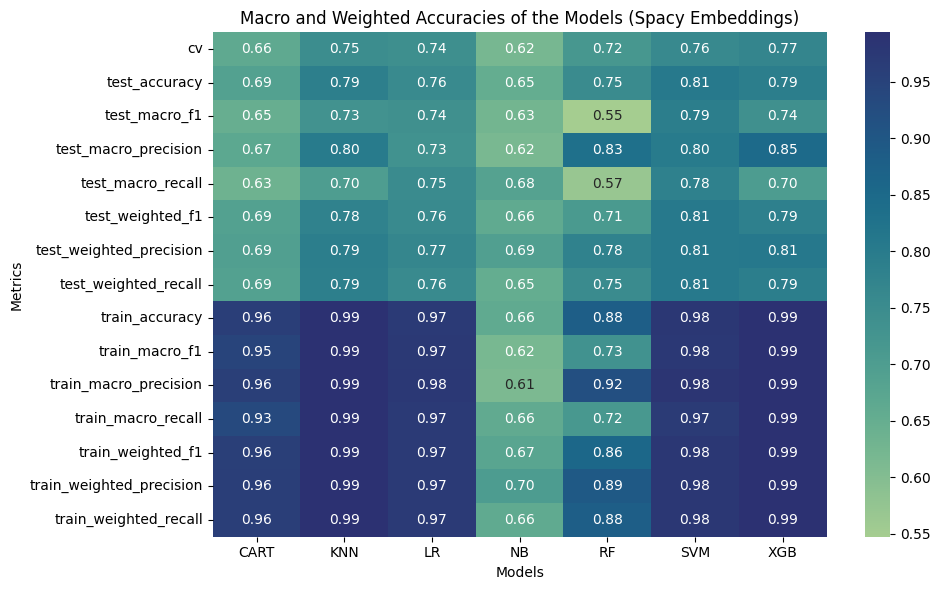

In [35]:
#### wihout stop word
evals_nlp.plot_results()

## LSTM

In [66]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, AdamW
class SentimentAnalysisPipeline:
    def __init__(self, data, embeddings, labels, lstm_units=32, dropout_rate=0.5):
        self.data = data
        self.embeddings = embeddings
        self.labels = labels
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.num_classes = None
        self.label_encoder = None
        self.model = None
        print("Pipeline initialized!")

    def preprocess_data(self):
        assert len(self.embeddings) == len(self.data), "Embeddings and data size mismatch!"
        labels = self.data[self.labels]
        self.label_encoder = LabelEncoder()
        labels = self.label_encoder.fit_transform(labels)
        self.num_classes = len(set(labels))
        y = to_categorical(labels, self.num_classes)
        x_train, x_test, y_train, y_test = train_test_split(
            self.embeddings, y, test_size=0.2, random_state=42
        )
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
        print(f"Data preprocessed! Training samples: {len(x_train)}, Testing samples: {len(x_test)}")
        return x_train, x_test, y_train, y_test


    def macro_f1(self, y_true, y_pred):
        # Convert probabilities to predicted labels
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true_classes = tf.argmax(y_true, axis=1)
        f1_scores = []
        for class_id in range(self.num_classes):
            # True Positives, False Positives, False Negatives
            tp = tf.reduce_sum(tf.cast(
                tf.logical_and(tf.equal(y_pred_classes, class_id),
                             tf.equal(y_true_classes, class_id)),
                tf.float32))
            fp = tf.reduce_sum(tf.cast(
                tf.logical_and(tf.equal(y_pred_classes, class_id),
                             tf.not_equal(y_true_classes, class_id)),
                tf.float32))
            fn = tf.reduce_sum(tf.cast(
                tf.logical_and(tf.not_equal(y_pred_classes, class_id),
                             tf.equal(y_true_classes, class_id)),
                tf.float32))
            
            precision = tp / (tp + fp + tf.keras.backend.epsilon())
            recall = tp / (tp + fn + tf.keras.backend.epsilon())

            f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
            f1_scores.append(f1)
        return tf.reduce_mean(f1_scores)

    def weighted_f1(self, y_true, y_pred):
        # Converting probabilities to predicted labels
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true_classes = tf.argmax(y_true, axis=1)
        
        f1_scores = []
        weights = []
        
        for class_id in range(self.num_classes):
            # True Positives, False Positives, False Negatives
            tp = tf.reduce_sum(tf.cast(
                tf.logical_and(tf.equal(y_pred_classes, class_id),
                             tf.equal(y_true_classes, class_id)),
                tf.float32))
            fp = tf.reduce_sum(tf.cast(
                tf.logical_and(tf.equal(y_pred_classes, class_id),
                             tf.not_equal(y_true_classes, class_id)),
                tf.float32))
            fn = tf.reduce_sum(tf.cast(
                tf.logical_and(tf.not_equal(y_pred_classes, class_id),
                             tf.equal(y_true_classes, class_id)),
                tf.float32))
            
            #  weight (number of samples in this class)
            weight = tf.reduce_sum(tf.cast(tf.equal(y_true_classes, class_id), tf.float32))
            weights.append(weight)
            
            # precision and recall
            precision = tp / (tp + fp + tf.keras.backend.epsilon())
            recall = tp / (tp + fn + tf.keras.backend.epsilon())
            
            #  F1 score
            f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
            f1_scores.append(f1)
        
        # Converting to tensors
        f1_scores = tf.stack(f1_scores)
        weights = tf.stack(weights)
        weights = weights / tf.reduce_sum(weights)
        return tf.reduce_sum(f1_scores * weights)

    def build_model_tuner(self, hp):
        # Setting hyperparameter ranges
        optimizer_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
        lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        use_adamw = hp.Boolean('use_adamw')

        # Building model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(
            lstm_units, 
            input_shape=(1, self.embeddings.shape[1]), 
            return_sequences=False
        ))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.Dense(self.num_classes, activation='softmax'))

        # Configuring  optimizer
        if use_adamw:
            optimizer = tf.keras.optimizers.AdamW(learning_rate=optimizer_learning_rate)
        else:
            optimizer = tf.keras.optimizers.Adam(learning_rate=optimizer_learning_rate)

        # Compile model
        model.compile(
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            optimizer=optimizer,
            metrics=[self.macro_f1, self.weighted_f1]
        )
        
        return model

    def tune_hyperparameters(self, x_train, y_train, max_trials=10, 
                           executions_per_trial=2, directory='my_dir', 
                           project_name='sentiment_analysis'):
        # tuner
        tuner = kt.Hyperband(
            self.build_model_tuner,
            objective=kt.Objective("val_macro_f1", direction="max"),
            max_epochs=10,
            factor=3,
            directory=directory,
            project_name=project_name,
            executions_per_trial=executions_per_trial
        )

        #early stopping
        stop_early = tf.keras.callbacks.EarlyStopping(
            monitor='val_macro_f1',
            mode='max',
            patience=3
        )

        #hyperparameter search
        tuner.search(
            x_train, 
            y_train,
            validation_split=0.2,
            callbacks=[stop_early]
        )

        # best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f"Best Hyperparameters: "
              f"LSTM Units: {best_hps.get('lstm_units')}, "
              f"Dropout Rate: {best_hps.get('dropout_rate')}, "
              f"Learning Rate: {best_hps.get('learning_rate')}, "
              f"Use AdamW: {best_hps.get('use_adamw')}")

        # model with best hyperparameters
        self.model = tuner.hypermodel.build(best_hps)
        
        return best_hps

    def train_model(self, x_train, y_train, batch_size=32, epochs=10):
        early_stopping = EarlyStopping(
            monitor='val_macro_f1',
            mode='max',
            patience=3,
            restore_best_weights=True
        )
        lr_scheduler = ReduceLROnPlateau(
            monitor='val_macro_f1',
            mode='max',
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )
        history = self.model.fit(
            x_train, y_train,
            validation_split=0.2,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stopping, lr_scheduler],
            verbose=1
        )
        print("Model training completed!")
        return history

    def evaluate_model(self, x_data, y_data, data_type="Test"):
        y_pred_probs = self.model.predict(x_data)
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        y_true_classes = np.argmax(y_data, axis=1)
        # detailed classification report
        report = classification_report(
            y_true_classes, y_pred_classes,
            target_names=self.label_encoder.classes_,
            output_dict=True
        )
        print(f"\n{data_type} Set Evaluation:")
        print("=" * 50)
        
        print("\nPer-class Metrics:")
        print("-" * 20)
        for class_name in self.label_encoder.classes_:
            class_metrics = report[class_name]
            print(f"\nClass: {class_name}")
            print(f"Precision: {class_metrics['precision']:.4f}")
            print(f"Recall:    {class_metrics['recall']:.4f}")
            print(f"F1-Score:  {class_metrics['f1-score']:.4f}")
            print(f"Support:   {class_metrics['support']}")

        #  macro-averaged metrics
        print("\nMacro-averaged Metrics:")
        print("-" * 20)
        print(f"Precision: {report['macro avg']['precision']:.4f}")
        print(f"Recall:    {report['macro avg']['recall']:.4f}")
        print(f"F1-Score:  {report['macro avg']['f1-score']:.4f}")

        # weighted-averaged metrics
        print("\nWeighted-averaged Metrics:")
        print("-" * 20)
        print(f"Precision: {report['weighted avg']['precision']:.4f}")
        print(f"Recall:    {report['weighted avg']['recall']:.4f}")
        print(f"F1-Score:  {report['weighted avg']['f1-score']:.4f}")

        # confusion matrix
        print(f"\n{data_type} Confusion Matrix:")
        print("-" * 20)
        conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
        print(conf_matrix)

        return report, conf_matrix

    def plot_training_history(self, history):
        plt.figure(figsize=(12, 4))
        
        # training history
        plt.subplot(1, 2, 1)
        plt.plot(history.history['macro_f1'], label='Training Macro F1')
        plt.plot(history.history['val_macro_f1'], label='Validation Macro F1')
        plt.title('Model Macro F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('Macro F1 Score')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['weighted_f1'], label='Training Weighted F1')
        plt.plot(history.history['val_weighted_f1'], label='Validation Weighted F1')
        plt.title('Model Weighted F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('Weighted F1 Score')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

### With DistilBert Embeddings

In [67]:
pipeline = SentimentAnalysisPipeline(
    data=data,
    embeddings=reduced_embeddings,  # Precomputed embeddings
    labels="sentiment_gpt"  # Column name for the labels
)

Pipeline initialized!


In [68]:
x_train, x_test, y_train, y_test = pipeline.preprocess_data()

Data preprocessed! Training samples: 1093, Testing samples: 274


In [69]:
best_hps = pipeline.tune_hyperparameters(x_train, y_train, max_trials=10)

Trial 30 Complete [00h 00m 17s]
val_macro_f1: 0.4799397736787796

Best val_macro_f1 So Far: 0.7074026167392731
Total elapsed time: 00h 06m 43s
Best Hyperparameters: LSTM Units: 32, Dropout Rate: 0.1, Learning Rate: 0.01, Use AdamW: False


In [134]:
# pipeline.build_model()

Model built and compiled!


In [70]:
history = pipeline.train_model(x_train, y_train)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0196 - macro_f1: 0.4187 - weighted_f1: 0.5169 - val_loss: 0.7711 - val_macro_f1: 0.5260 - val_weighted_f1: 0.6621 - learning_rate: 0.0100
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7236 - macro_f1: 0.5976 - weighted_f1: 0.7208 - val_loss: 0.7262 - val_macro_f1: 0.6595 - val_weighted_f1: 0.7286 - learning_rate: 0.0100
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6112 - macro_f1: 0.7638 - weighted_f1: 0.8126 - val_loss: 0.7150 - val_macro_f1: 0.6455 - val_weighted_f1: 0.7315 - learning_rate: 0.0100
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5869 - macro_f1: 0.7993 - weighted_f1: 0.8385 - val_loss: 0.7357 - val_macro_f1: 0.6649 - val_weighted_f1: 0.7248 - learning_rate: 0.0100
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5169 - macro_f1: 0.8251 - weighted_f1: 0.8891 - val_loss: 0.7576 - val_macro_f1: 0.6796 - val_weighted_f1: 0.7292 - learning_rate: 0.0100
Epoch 6/1

In [71]:
pipeline.evaluate_model(x_test, y_test)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Test Set Evaluation:

Per-class Metrics:
--------------------

Class: Negative
Precision: 0.7929
Recall:    0.7817
F1-Score:  0.7872
Support:   142.0

Class: Neutral
Precision: 0.6897
Recall:    0.8000
F1-Score:  0.7407
Support:   100.0

Class: Positive
Precision: 0.7222
Recall:    0.4062
F1-Score:  0.5200
Support:   32.0

Macro-averaged Metrics:
--------------------
Precision: 0.7349
Recall:    0.6626
F1-Score:  0.6827

Weighted-averaged Metrics:
--------------------
Precision: 0.7469
Recall:    0.7445
F1-Score:  0.7391

Test Confusion Matrix:
--------------------
[[111  29   2]
 [ 17  80   3]
 [ 12   7  13]]


({'Negative': {'precision': 0.7928571428571428,
   'recall': 0.7816901408450704,
   'f1-score': 0.7872340425531915,
   'support': 142.0},
  'Neutral': {'precision': 0.6896551724137931,
   'recall': 0.8,
   'f1-score': 0.7407407407407407,
   'support': 100.0},
  'Positive': {'precision': 0.7222222222222222,
   'recall': 0.40625,
   'f1-score': 0.52,
   'support': 32.0},
  'accuracy': 0.7445255474452555,
  'macro avg': {'precision': 0.7349115124977194,
   'recall': 0.6626467136150235,
   'f1-score': 0.6826582610979774,
   'support': 274.0},
  'weighted avg': {'precision': 0.7469428563438127,
   'recall': 0.7445255474452555,
   'f1-score': 0.7390558690387857,
   'support': 274.0}},
 array([[111,  29,   2],
        [ 17,  80,   3],
        [ 12,   7,  13]], dtype=int64))

In [73]:
pipeline.evaluate_model(x_train, y_train)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Test Set Evaluation:

Per-class Metrics:
--------------------

Class: Negative
Precision: 0.8935
Recall:    0.9259
F1-Score:  0.9094
Support:   553.0

Class: Neutral
Precision: 0.8919
Recall:    0.8789
F1-Score:  0.8854
Support:   413.0

Class: Positive
Precision: 0.9027
Recall:    0.8031
F1-Score:  0.8500
Support:   127.0

Macro-averaged Metrics:
--------------------
Precision: 0.8960
Recall:    0.8693
F1-Score:  0.8816

Weighted-averaged Metrics:
--------------------
Precision: 0.8940
Recall:    0.8939
F1-Score:  0.8934

Test Confusion Matrix:
--------------------
[[512  33   8]
 [ 47 363   3]
 [ 14  11 102]]


({'Negative': {'precision': 0.893542757417103,
   'recall': 0.9258589511754068,
   'f1-score': 0.9094138543516874,
   'support': 553.0},
  'Neutral': {'precision': 0.8918918918918919,
   'recall': 0.8789346246973365,
   'f1-score': 0.8853658536585366,
   'support': 413.0},
  'Positive': {'precision': 0.9026548672566371,
   'recall': 0.8031496062992126,
   'f1-score': 0.85,
   'support': 127.0},
  'accuracy': 0.8938700823421775,
  'macro avg': {'precision': 0.8960298388552107,
   'recall': 0.8693143940573186,
   'f1-score': 0.881593236003408,
   'support': 1093.0},
  'weighted avg': {'precision': 0.893977734990487,
   'recall': 0.8938700823421775,
   'f1-score': 0.8934235672620849,
   'support': 1093.0}},
 array([[512,  33,   8],
        [ 47, 363,   3],
        [ 14,  11, 102]], dtype=int64))

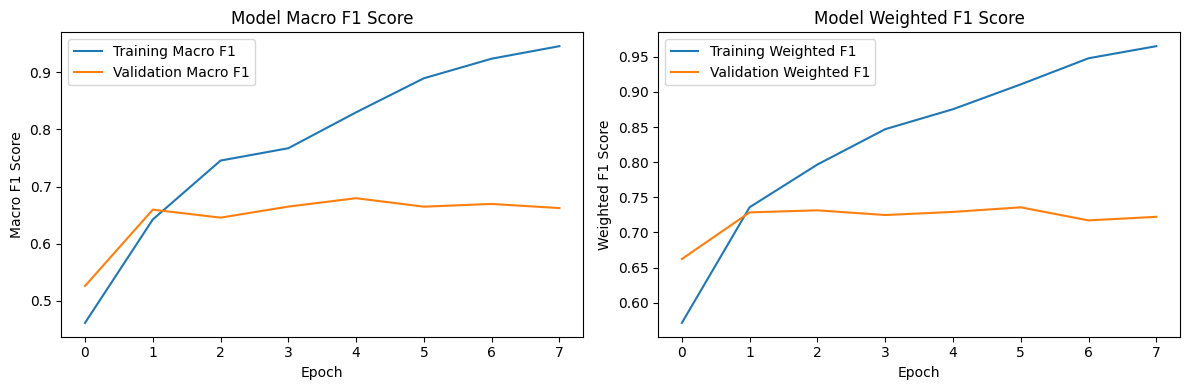

In [72]:
pipeline.plot_training_history(history)

### With Spacy Embeddings

In [96]:
pipeline = SentimentAnalysisPipeline(
    data=data,
    embeddings=embeddings,  # Precomputed embeddings
    labels="sentiment_gpt"  # Column name for the labels
)

Pipeline initialized!


In [97]:
x_train, x_test, y_train, y_test = pipeline.preprocess_data()

Data preprocessed! Training samples: 1093, Testing samples: 274


In [98]:
best_hps = pipeline.tune_hyperparameters(x_train, y_train)

Trial 30 Complete [00h 00m 21s]
val_macro_f1: 0.36161646246910095

Best val_macro_f1 So Far: 0.6937509775161743
Total elapsed time: 00h 09m 11s
Best Hyperparameters: LSTM Units: 96, Dropout Rate: 0.1, Learning Rate: 0.001, Use AdamW: True


In [99]:
history = pipeline.train_model(x_train, y_train)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.9855 - macro_f1: 0.3365 - weighted_f1: 0.4522 - val_loss: 0.8413 - val_macro_f1: 0.4456 - val_weighted_f1: 0.6230 - learning_rate: 0.0010
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8198 - macro_f1: 0.4649 - weighted_f1: 0.6319 - val_loss: 0.7758 - val_macro_f1: 0.4604 - val_weighted_f1: 0.6336 - learning_rate: 0.0010
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7746 - macro_f1: 0.5283 - weighted_f1: 0.6539 - val_loss: 0.7387 - val_macro_f1: 0.4884 - val_weighted_f1: 0.6568 - learning_rate: 0.0010
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7483 - macro_f1: 0.5849 - weighted_f1: 0.6991 - val_loss: 0.7229 - val_macro_f1: 0.6355 - val_weighted_f1: 0.7071 - learning_rate: 0.0010
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7327 - macro_f1: 0.6300 - weighted_f1: 0.7193 - val_loss: 0.7596 - val_macro_f1: 0.5941 - val_weighted_f1: 0.6742 - learning_rate: 0.0010
Epoch 6/1

In [100]:
pipeline.evaluate_model(x_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Test Set Evaluation:

Per-class Metrics:
--------------------

Class: Negative
Precision: 0.7448
Recall:    0.7606
F1-Score:  0.7526
Support:   142.0

Class: Neutral
Precision: 0.6574
Recall:    0.7100
F1-Score:  0.6827
Support:   100.0

Class: Positive
Precision: 0.5238
Recall:    0.3438
F1-Score:  0.4151
Support:   32.0

Macro-averaged Metrics:
--------------------
Precision: 0.6420
Recall:    0.6048
F1-Score:  0.6168

Weighted-averaged Metrics:
--------------------
Precision: 0.6871
Recall:    0.6934
F1-Score:  0.6877

Test Confusion Matrix:
--------------------
[[108  30   4]
 [ 23  71   6]
 [ 14   7  11]]


({'Negative': {'precision': 0.7448275862068966,
   'recall': 0.7605633802816901,
   'f1-score': 0.7526132404181185,
   'support': 142.0},
  'Neutral': {'precision': 0.6574074074074074,
   'recall': 0.71,
   'f1-score': 0.6826923076923077,
   'support': 100.0},
  'Positive': {'precision': 0.5238095238095238,
   'recall': 0.34375,
   'f1-score': 0.41509433962264153,
   'support': 32.0},
  'accuracy': 0.6934306569343066,
  'macro avg': {'precision': 0.642014839141276,
   'recall': 0.6047711267605633,
   'f1-score': 0.6167999625776893,
   'support': 274.0},
  'weighted avg': {'precision': 0.68711008300739,
   'recall': 0.6934306569343066,
   'f1-score': 0.6876763860457231,
   'support': 274.0}},
 array([[108,  30,   4],
        [ 23,  71,   6],
        [ 14,   7,  11]], dtype=int64))

In [101]:
pipeline.evaluate_model(x_train, y_train)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Test Set Evaluation:

Per-class Metrics:
--------------------

Class: Negative
Precision: 0.8226
Recall:    0.8807
F1-Score:  0.8507
Support:   553.0

Class: Neutral
Precision: 0.8150
Recall:    0.7361
F1-Score:  0.7735
Support:   413.0

Class: Positive
Precision: 0.6719
Recall:    0.6772
F1-Score:  0.6745
Support:   127.0

Macro-averaged Metrics:
--------------------
Precision: 0.7698
Recall:    0.7646
F1-Score:  0.7662

Weighted-averaged Metrics:
--------------------
Precision: 0.8022
Recall:    0.8024
F1-Score:  0.8010

Test Confusion Matrix:
--------------------
[[487  49  17]
 [ 84 304  25]
 [ 21  20  86]]


({'Negative': {'precision': 0.8226351351351351,
   'recall': 0.8806509945750453,
   'f1-score': 0.8506550218340612,
   'support': 553.0},
  'Neutral': {'precision': 0.8150134048257373,
   'recall': 0.7360774818401937,
   'f1-score': 0.7735368956743003,
   'support': 413.0},
  'Positive': {'precision': 0.671875,
   'recall': 0.6771653543307087,
   'f1-score': 0.6745098039215687,
   'support': 127.0},
  'accuracy': 0.8023787740164684,
  'macro avg': {'precision': 0.7698411799869574,
   'recall': 0.764631276915316,
   'f1-score': 0.7662339071433101,
   'support': 1093.0},
  'weighted avg': {'precision': 0.8022377776054521,
   'recall': 0.8023787740164684,
   'f1-score': 0.8010482251470824,
   'support': 1093.0}},
 array([[487,  49,  17],
        [ 84, 304,  25],
        [ 21,  20,  86]], dtype=int64))

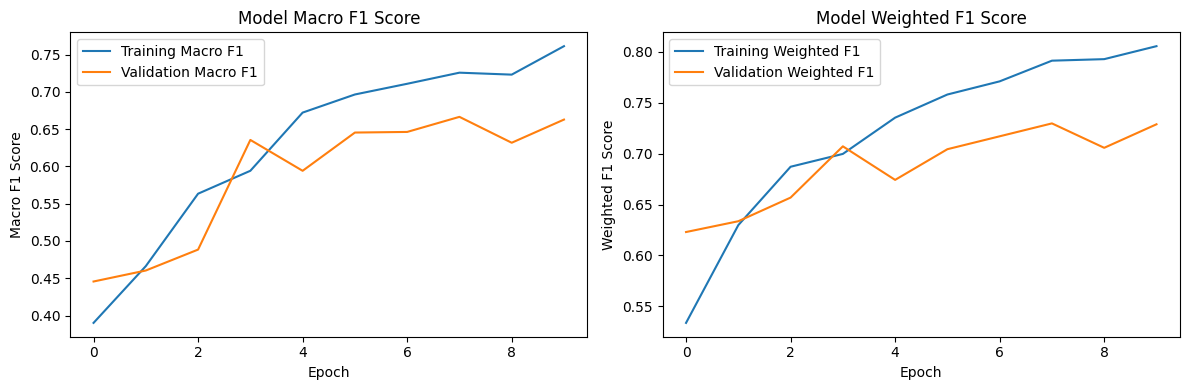

In [102]:
pipeline.plot_training_history(history)